Finetune a Pretrained Hugginface model

In [ ]:
!pip install transformers
!pip install transformers[torch]

In [ ]:
!pip install datasets

In [ ]:
!pip install accelerate -U

In [ ]:
#Import Libraries
import os

#Data manipulation
import pandas as pd
import numpy as np
import datasets
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import seaborn as sns

#finetuning
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer

#Evaluation
from datasets import load_dataset #,load_metric,
from sklearn.metrics import f1_score
from huggingface_hub import notebook_login


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#login to huggingface
notebook_login()

Activate weight and Biases

In [ ]:
os.environ["WANDB_DISABLED"] = "false"

Load The Datasets

In [ ]:
# prompt: read 3 sheets in excel file to a single dataframe

import pandas as pd

# Specify the path to your Excel file
excel_file = '/content/drive/MyDrive/Nors/Euphemisms of Death/Euphemism Segments (MeMo corpus)_extended.xlsx'

# Read the sheets into separate DataFrames
df1 = pd.read_excel(excel_file, sheet_name='Training Set (Alex)')
df2 = pd.read_excel(excel_file, sheet_name='Training Set (Bolette)')
df3 = pd.read_excel(excel_file, sheet_name='Training Set (Jens)')

# Concatenate the DataFrames
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

# Now combined_df contains data from all three sheets
print(combined_df)


                                       Sentence_before  \
0    Hun bedrager migi — gispede han mellem de samm...   
1    Og endda hun havde gået og glæd sig til at for...   
2    klosterbo . Hvad vil du da ? Vil du sidde her ...   
3    „ Kære , gamle ven ! „ Med dyb bekjymring må j...   
4    „ hendes sidste levedage ; jeg formoder hun vi...   
..                                                 ...   
669  munden , således som han ofte havde været at s...   
670  blev bestyret af Karen , en ældre pige , der h...   
671  åndfuld . . . så . . . « Fruen havde dyb ringe...   
672  forældrene istemme : nu lader os da grave ned ...   
673  Hans excellence veg ikke fra det leje , nonner...   

                                              Sentence  \
0    er opvokset i sådanne omgivelser ? For en smer...   
1    git hende mod til at komme hjem , for ellers h...   
2      Når din moder er vandret heden , og denne smule   
3    „ min eneste søn er afgået ved døden , efter e...   
4          „ 

In [ ]:
df = combined_df
df.head()


,Sentence_before,Sentence,Sentence_after,Filename,Year,Match,Phrase Key,Is Death Euphemism? (Yes/No)
0,Hun bedrager migi — gispede han mellem de samm...,er opvokset i sådanne omgivelser ? For en smer...,"simpelthen sige hende , at jeg ved og forstår ...",1893_Schoeyen_EtLoefte.txt,1893,kommer hjem,kom* hjem,No
1,Og endda hun havde gået og glæd sig til at for...,"git hende mod til at komme hjem , for ellers h...","hun da aldrig vovet at vise sig for ham mere ,...",1888_SkramA_Lucie.txt,1888,komme hjem,kom* hjem,No
2,klosterbo . Hvad vil du da ? Vil du sidde her ...,"Når din moder er vandret heden , og denne smule","jord , som endda kun til hælvten er din moders...",1896_EwaldHF_LidenKirsten.txt,1896,vandret heden,vandr* heden,Yes
3,"„ Kære , gamle ven ! „ Med dyb bekjymring må j...","„ min eneste søn er afgået ved døden , efter e...",„ smertefuldt sygeleje . Jeg var hos ham i han...,1872_LeFevre_DianaEllerHaabloesKjaerlighed.txt,1872,afgået ved døden,afg* ved døden,Yes
4,„ hendes sidste levedage ; jeg formoder hun vi...,"„ vandrer heden . Bed ham komme herhen , så",„ hurtigt som muligt . “ Det var efter modtage...,1870_GB_PolitispionenEllerHaelerhusetPaaKristi...,1870,vandrer heden,vandr* heden,Yes


In [ ]:
# prompt: replace the phrase in the sentence column equal to the phrase in Match column with “[PET_BOUNDARY]Match“[PET_BOUNDARY]

def replace_phrase(row):
  sentence = row['Sentence']
  match = row['Match']
  sentence = sentence.replace(match, "[PET_BOUNDARY]" + match + "[PET_BOUNDARY]")
  return sentence

df['Sentence'] = df.apply(replace_phrase, axis=1)


In [ ]:
# prompt: print first 10 sentences in the Sentence column and first 10 in Match column

print(df['Sentence'].head(10))
print(df['Match'].head(10))


0    er opvokset i sådanne omgivelser ? For en smer...
1    git hende mod til at [PET_BOUNDARY]komme hjem[...
2    Når din moder er [PET_BOUNDARY]vandret heden[P...
3    „ min eneste søn er [PET_BOUNDARY]afgået ved d...
4    „ [PET_BOUNDARY]vandrer heden[PET_BOUNDARY] . ...
5              [PET_BOUNDARY]himlede[PET_BOUNDARY] . “
6    indtil hun omsider [PET_BOUNDARY]udåndede[PET_...
7    ikke , når jeg [PET_BOUNDARY]kommer hjem[PET_B...
8    [PET_BOUNDARY]hensovet[PET_BOUNDARY] , « — beg...
9    og [PET_BOUNDARY]går i graven[PET_BOUNDARY] , ...
Name: Sentence, dtype: object
0         kommer hjem
1          komme hjem
2       vandret heden
3    afgået ved døden
4       vandrer heden
5             himlede
6            udåndede
7         kommer hjem
8            hensovet
9        går i graven
Name: Match, dtype: object


In [ ]:
# prompt: how to combine Sentence_before, Sentence, and Sentence_after to be a new column called text

df['text'] = df['Sentence_before'] + ' ' + df['Sentence'] + ' ' + df['Sentence_after']
df.head()

,Sentence_before,Sentence,Sentence_after,Filename,Year,Match,Phrase Key,Is Death Euphemism? (Yes/No),text
0,Hun bedrager migi — gispede han mellem de samm...,er opvokset i sådanne omgivelser ? For en smer...,"simpelthen sige hende , at jeg ved og forstår ...",1893_Schoeyen_EtLoefte.txt,1893,kommer hjem,kom* hjem,No,Hun bedrager migi — gispede han mellem de samm...
1,Og endda hun havde gået og glæd sig til at for...,git hende mod til at [PET_BOUNDARY]komme hjem[...,"hun da aldrig vovet at vise sig for ham mere ,...",1888_SkramA_Lucie.txt,1888,komme hjem,kom* hjem,No,Og endda hun havde gået og glæd sig til at for...
2,klosterbo . Hvad vil du da ? Vil du sidde her ...,Når din moder er [PET_BOUNDARY]vandret heden[P...,"jord , som endda kun til hælvten er din moders...",1896_EwaldHF_LidenKirsten.txt,1896,vandret heden,vandr* heden,Yes,klosterbo . Hvad vil du da ? Vil du sidde her ...
3,"„ Kære , gamle ven ! „ Med dyb bekjymring må j...",„ min eneste søn er [PET_BOUNDARY]afgået ved d...,„ smertefuldt sygeleje . Jeg var hos ham i han...,1872_LeFevre_DianaEllerHaabloesKjaerlighed.txt,1872,afgået ved døden,afg* ved døden,Yes,"„ Kære , gamle ven ! „ Med dyb bekjymring må j..."
4,„ hendes sidste levedage ; jeg formoder hun vi...,„ [PET_BOUNDARY]vandrer heden[PET_BOUNDARY] . ...,„ hurtigt som muligt . “ Det var efter modtage...,1870_GB_PolitispionenEllerHaelerhusetPaaKristi...,1870,vandrer heden,vandr* heden,Yes,„ hendes sidste levedage ; jeg formoder hun vi...


In [ ]:
# prompt: change the Is Death Euphemism? (Yes/No)	into label

df = df.rename(columns={'Is Death Euphemism? (Yes/No)':'label'})
df.head()

,Sentence_before,Sentence,Sentence_after,Filename,Year,Match,Phrase Key,label,text
0,Hun bedrager migi — gispede han mellem de samm...,er opvokset i sådanne omgivelser ? For en smer...,"simpelthen sige hende , at jeg ved og forstår ...",1893_Schoeyen_EtLoefte.txt,1893,kommer hjem,kom* hjem,No,Hun bedrager migi — gispede han mellem de samm...
1,Og endda hun havde gået og glæd sig til at for...,git hende mod til at [PET_BOUNDARY]komme hjem[...,"hun da aldrig vovet at vise sig for ham mere ,...",1888_SkramA_Lucie.txt,1888,komme hjem,kom* hjem,No,Og endda hun havde gået og glæd sig til at for...
2,klosterbo . Hvad vil du da ? Vil du sidde her ...,Når din moder er [PET_BOUNDARY]vandret heden[P...,"jord , som endda kun til hælvten er din moders...",1896_EwaldHF_LidenKirsten.txt,1896,vandret heden,vandr* heden,Yes,klosterbo . Hvad vil du da ? Vil du sidde her ...
3,"„ Kære , gamle ven ! „ Med dyb bekjymring må j...",„ min eneste søn er [PET_BOUNDARY]afgået ved d...,„ smertefuldt sygeleje . Jeg var hos ham i han...,1872_LeFevre_DianaEllerHaabloesKjaerlighed.txt,1872,afgået ved døden,afg* ved døden,Yes,"„ Kære , gamle ven ! „ Med dyb bekjymring må j..."
4,„ hendes sidste levedage ; jeg formoder hun vi...,„ [PET_BOUNDARY]vandrer heden[PET_BOUNDARY] . ...,„ hurtigt som muligt . “ Det var efter modtage...,1870_GB_PolitispionenEllerHaelerhusetPaaKristi...,1870,vandrer heden,vandr* heden,Yes,„ hendes sidste levedage ; jeg formoder hun vi...


In [ ]:
df['label'].value_counts()

,count
label,
Yes,345
No,329


In [ ]:
train_df = df
train_df['label'].value_counts()

,count
label,
Yes,345
No,329


In [ ]:
# Specify the columns you want to keep
columns_to_keep = ['text', 'label']

# Drop all columns except the specified ones
train_df = train_df[columns_to_keep]

In [ ]:
# Create a dictionary to map the values
value_map = {
    'No': '0',
    'Yes': '1',
}

# Apply the mapping to the column
train_df['label'] = train_df['label'].map(value_map)

<ipython-input-40-769df9e2b4c4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = train_df['label'].map(value_map)


In [ ]:
train_df

,text,label
0,Hun bedrager migi — gispede han mellem de samm...,0
1,Og endda hun havde gået og glæd sig til at for...,0
2,klosterbo . Hvad vil du da ? Vil du sidde her ...,1
3,"„ Kære , gamle ven ! „ Med dyb bekjymring må j...",1
4,„ hendes sidste levedage ; jeg formoder hun vi...,1
...,...,...
669,"munden , således som han ofte havde været at s...",1
670,"blev bestyret af Karen , en ældre pige , der h...",1
671,åndfuld . . . så . . . « Fruen havde dyb ringe...,0
672,forældrene istemme : nu lader os da grave ned ...,1


In [ ]:
#view info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    674 non-null    object
 1   label   674 non-null    object
dtypes: object(2)
memory usage: 10.7+ KB


# Remove the rows with null values in the label and agreement columns of the train_df DataFrame

In [ ]:
# Remove rows with null values
train_df.dropna(subset=['label', 'text'], inplace=True)

<ipython-input-43-662a41dc8b53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(subset=['label', 'text'], inplace=True)


In [ ]:
# View info once again
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    674 non-null    object
 1   label   674 non-null    object
dtypes: object(2)
memory usage: 10.7+ KB


**Danish Text Preprocessing**

In [ ]:
#danish text preproccessing
import re
import nltk
import string

nltk.download('punkt')
nltk.download("stopwords")

def preprocess_danish(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(text.maketrans("", "", string.punctuation))
    # text = re.sub(r'[^a-zA-ZæøåÆØÅ]', ' ', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords (optional)
    #nltk.download('stopwords')
    from nltk.corpus import stopwords
    #stop_words = set(stopwords.words("danish"))
    #tokens = [word for word in tokens if word not in stop_words]

    return (" ".join(tokens))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Apply Text Preprocessing**

In [ ]:
# Apply the preprocessing function to the 'text_column' using apply
print(train_df['text'][:2])
train_df['text'] = train_df['text'].apply(preprocess_danish)
print()
print(train_df['text'][:2])
train_df['text'] = train_df['text'].str.strip()


0    Hun bedrager migi — gispede han mellem de samm...
1    Og endda hun havde gået og glæd sig til at for...
Name: text, dtype: object

0    hun bedrager migi — gispede han mellem de samm...
1    og endda hun havde gået og glæd sig til at for...
Name: text, dtype: object


<ipython-input-27-cb4412434d01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply(preprocess_danish)
<ipython-input-27-cb4412434d01>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].str.strip()


In [ ]:
print(train_df['text'][:20])

0     Hun bedrager migi — gispede han mellem de samm...
1     Og endda hun havde gået og glæd sig til at for...
2     klosterbo . Hvad vil du da ? Vil du sidde her ...
3     „ Kære , gamle ven ! „ Med dyb bekjymring må j...
4     „ hendes sidste levedage ; jeg formoder hun vi...
5     „ Jeg tænker , at han mente det værste , “ sva...
6     grønne karaffels indhold . » Å ! — å ! « lød d...
7     min hustrues død været så bedrøvet som i aften...
8     kvadratur jeg ! » Abraham Johnston er stille o...
9     Mylr ? Fører ikke de gg hundrededele af jorden...
10    Men for Margrete vare disse sidste dage forund...
11    tænkte Kjeld med bitterhed ; dog for hans øre ...
12    kilde falden i god jord , og kirkens blomsterh...
13    Vær du vor hjælper ! “ * ) den lille sum , Fru...
14    ulykke , siden Viktor i det mindste foreløbig ...
15    som en mus . Det skulle ikke undre mig , om en...
16    men i den ; så længe kornet er oven jorden , s...
17    Lidt efter kom en ung pige op på bakken fr

In [ ]:
for sent in train_df['text'].tolist()[:20]:
    print(sent)

Hun bedrager migi — gispede han mellem de sammenbidte tænder , mens han arbejdede sig op og ned ad bakker , gennem skove , over marker . — hun bedrager mig ! Hun ligner hele sin slægt , individer uden ære , uden skamfølelse ! Hvordan skulle hun også kunne blive anderledes , når hun er opvokset i sådanne omgivelser ? For en smertefuld skuffelse ! For en lav , skændig forbrydelse ! Og jeg , som havde en så urokkelig tillid til hende ! Men når jeg nu [PET_BOUNDARY]kommer hjem[PET_BOUNDARY] , skal opgøret stå . Jeg vil kræve hende til regnskab , nej , simpelthen sige hende , at jeg ved og forstår alt , og at jeg har forstået det længe . Jeg vil knuse hende med min foragt , trampe på hende , bruge de stærkeste udtryk . Men der findes ikke ord stærke nok til at udtrykke , hvad jeg føler og mener . Bedrage , hykle , lyve i ord og miner , skænde mit hjem , tilsmudse mit navn ! . . . . Hun er et væsen uden ære , uden gnist af samvittighed , uden spor af hjerte ! . . . . Et dyr . .
Og endda hun 

## tweet_id is an object, the tweet is an object as expected while label and agreements are floats

In [ ]:
#look at some of the tweets and how they are written
for tweet in range(10):
    tweet_str=train_df['text'][tweet]
    print(f'{tweet_str}\n')

Hun bedrager migi — gispede han mellem de sammenbidte tænder , mens han arbejdede sig op og ned ad bakker , gennem skove , over marker . — hun bedrager mig ! Hun ligner hele sin slægt , individer uden ære , uden skamfølelse ! Hvordan skulle hun også kunne blive anderledes , når hun er opvokset i sådanne omgivelser ? For en smertefuld skuffelse ! For en lav , skændig forbrydelse ! Og jeg , som havde en så urokkelig tillid til hende ! Men når jeg nu [PET_BOUNDARY]kommer hjem[PET_BOUNDARY] , skal opgøret stå . Jeg vil kræve hende til regnskab , nej , simpelthen sige hende , at jeg ved og forstår alt , og at jeg har forstået det længe . Jeg vil knuse hende med min foragt , trampe på hende , bruge de stærkeste udtryk . Men der findes ikke ord stærke nok til at udtrykke , hvad jeg føler og mener . Bedrage , hykle , lyve i ord og miner , skænde mit hjem , tilsmudse mit navn ! . . . . Hun er et væsen uden ære , uden gnist af samvittighed , uden spor af hjerte ! . . . . Et dyr . .

Og endda hun

## Revert to original Dataset

In [ ]:
train_df.drop(train_df.columns.difference(['text', 'label']), axis=1, inplace=True)

<ipython-input-48-23126ca4e757>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(train_df.columns.difference(['text', 'label']), axis=1, inplace=True)


AS Noticed in EDA we will drop the rows with missing values

In [ ]:
#Drop null rows
train_df.dropna(axis=0,inplace=True)

#check for the presence of null values again
train_df.isna().sum()


<ipython-input-49-d92b47589fe5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(axis=0,inplace=True)


,0
text,0
label,0


In [ ]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

Split the Train the dataset into training(for learning ) and evaluation(For computing metrics to capture overfitting) sets

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import train_test_split


df = train_df

# Split the DataFrame with stratification based on the 'label' column
df_85, df_15 = train_test_split(df, test_size=0.18, random_state=42, stratify=df['label'])

# Print the shapes of the resulting DataFrames to verify
print(f"85% of data: {df_85.shape}")
print(f"15% of data: {df_15.shape}")


85% of data: (552, 2)
15% of data: (122, 2)


In [ ]:
# train , eval = train_test_split(train_df,train_size=0.8,stratify=train_df['label'])
train = df_85
eval = df_15


In [ ]:
# Function to check if the value contains more than one word
def more_than_one_word(text):
    return len(text.split()) > 1

# Apply the function and filter the DataFrame
train = train[train['text'].apply(more_than_one_word)]
eval = eval[eval['text'].apply(more_than_one_word)]

check train data

In [ ]:
train.head()

,text,label
490,"den tør sige sig selv , at aldrig er noget for...",0
211,vogndøren reven op . Inden Hubert kunne tænke ...,0
224,han hænderne fromt over sit bryst og lagde sig...,0
426,„ hendes sidste levedage ; jeg formoder hun vi...,1
146,formelig æsede solstegen i bordklædningens gam...,0


Check eval

In [ ]:
eval.head()

,text,label
312,bøjede sig sammen og slog sig på knæerne med h...,1
346,bygninger af flammerne og nedbrændte til grund...,1
310,"— ræk mig din hånd for sidste gang , Aron , st...",1
31,"„ Men undersøg dog først nøje , hvorledes alt ...",1
594,og velsignede hende . Med sygeplejerskens hånd...,1


In [ ]:
eval['label'].value_counts()

,count
label,
1,62
0,60


In [ ]:
train['label'].value_counts()

,count
label,
1,283
0,269


Check the shapes of both dataset

In [ ]:
print(f'Shape of training set: {train.shape}\nShape of evaluation set: {eval.shape}')

Shape of training set: (552, 2)
Shape of evaluation set: (122, 2)


Save the splitted data to be loaded as huggingface dataset

In [ ]:
# Save splitted subsets
train.to_csv("/content/drive/MyDrive/Nors/Euphemisms of Death/Data/train_subset.csv", index=False)
eval.to_csv("/content/drive/MyDrive/Nors/Euphemisms of Death/Data/eval_subset.csv", index=False)

In [ ]:
datasets = load_dataset('csv',
                        data_files={'train':'/content/drive/MyDrive/Nors/Euphemisms of Death/Data/train_subset.csv',
                        'eval':'/content/drive/MyDrive/Nors/Euphemisms of Death/Data/eval_subset.csv'}, encoding = "utf-8")

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [ ]:
print(datasets['train'])

Dataset({
    features: ['text', 'label'],
    num_rows: 552
})


## Creating a Tokenizer instance

- The line of code below initializes a tokenizer for the "tweet_sentiments_analysis_roberta" model using the transformers library. The tokenizer is an essential component for processing text data and is used to convert input text into tokens that can be fed into the model for sentiment analysis.

In [ ]:
#Create a tokenizer instance
#KennethEnevoldsen/dfm-sentence-encoder-large
#MiMe-MeMo/MeMo-BERT-03
#NbAiLab/nb-bert-base
#vesteinn/DanskBERT
tokenizer=AutoTokenizer.from_pretrained('NbAiLab/nb-bert-base')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
tokenizer.model_max_length

1000000000000000019884624838656

## Functions to tokenize text and transform labels

The code below defines two functions: tokenize_data and transfom_label, both of which are used to preprocess data before feeding it into a model for sentiment analysis.

1. tokenize_data(data):

  - This function takes a data dictionary as input, which contains a key 'safe_text' representing the raw text to be tokenized.
  - It uses the tokenizer object (previously defined in the code) to tokenize the text data.
  - The padding='max_length' parameter specifies that the tokenized sequences should be padded to the maximum length of the input data to ensure uniformity for model processing.
  - The function then returns the tokenized data.

2. transfom_label(data):

  - This function takes a data dictionary as input, which contains a key 'label' representing the sentiment label (e.g., -1 for Negative, 0 for Neutral, 1 for Positive).
  - It maps the numerical sentiment labels to a unified label format suitable for model training and inference.
  - The function first extracts the 'label' value from the input data.
  - It then checks the value of 'label' and maps it to a numerical label representation (0 for Negative, 1 for Neutral, 2 for Positive).
  - The function returns a new dictionary containing the transformed 'labels' with the numerical representation.

*These functions play a crucial role in the data preprocessing pipeline before training the sentiment analysis model. The tokenize_data function converts the raw text data into tokenized sequences suitable for the model, while the transfom_label function converts the original sentiment labels into numerical representations that the model can understand during training and evaluation.*

In [ ]:
#function to tokenize text
def tokenize_data(data):
    return tokenizer(data['text'],padding='max_length',max_length=512, truncation=True)


#function to transform labels
def transfom_label(data):

    #extract label
    label=data['label']
    num=0
    #create contitions
    if label==0: #non noise
        num=0
    elif label==1: #noise
        num=1

    return {'labels':num}

## Tokenizer text and trasform original sentiment labels

The code below is part of a data preprocessing pipeline using the datasets module. The pipeline prepares the dataset for sentiment analysis using tokenization and label transformation. The dataset has the columns named 'tweet_id', 'label', 'safe_text', and 'agreement'.

1. remove_columns:

  - This is a list of column names that will be removed from the dataset after tokenization and label transformation. These columns are  not needed for model training and can be discarded.
2. datasets.map(tokenize_data, batched=True):

  - This line applies the tokenize_data function (previously defined in the code) to the dataset in a batched manner.
  - The tokenize_data function tokenizes the 'safe_text' column in the dataset, converting the raw text into tokenized sequences. The batched=True parameter indicates that the tokenization should be applied in batches to optimize efficiency.
3. datasets.map(transfom_label, remove_columns=remove_columns):

  - This line applies the transfom_label function (previously defined in the code) to the dataset.
  - The transfom_label function transforms the original sentiment labels in the 'label' column to numerical representations (0 for Negative, 1 for Neutral, 2 for Positive).
  - The remove_columns=remove_columns parameter ensures that the specified columns ('tweet_id', 'label', 'safe_text', 'agreement') are removed from the dataset after transformation, leaving only the tokenized text data and the numerical sentiment labels.

In [ ]:
#The following columns will be removed after tokenization
remove_columns = ['label', 'text']

#Tokenize the text data
datasets=datasets.map(tokenize_data,batched=True)

#transform the labels
datasets=datasets.map(transfom_label,remove_columns=remove_columns)

Map:   0%|          | 0/552 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Map:   0%|          | 0/552 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

## Extract the train and eval datasets from datasets
The code below does the following:

1. train_dataset = datasets['train'].shuffle(seed=0):

  - This line creates the training dataset by extracting the 'train' subset from the datasets variable using the key 'train'.
  - he shuffle(seed=0) function is applied to the 'train' subset. This function randomly shuffles the examples in the training dataset to ensure that the order of examples seen during training is randomized, which can lead to better generalization. The seed=0 parameter sets the random seed for reproducibility.
2. eval_dataset = datasets['eval'].shuffle(seed=0):

  - This line creates the evaluation dataset in a similar way to the training dataset.
  - The 'eval' subset is extracted from the datasets variable, and the shuffle() function is applied with the same random seed as in the previous line (seed=0).

In [ ]:
#extract train datasets
train_dataset=datasets['train'].shuffle(seed=0)
#extract eval datasets
eval_dataset=datasets['eval'].shuffle(seed=0)

## Define Metrics Function

The function below does the following:

1. def compute_metrics(eval_preds)::

  - This is the definition of a Python function named compute_metrics.
  - The function takes a single argument eval_preds, which is expected to be a tuple containing two arrays: logits and labels. These arrays are the predictions made by the model (logits) and the corresponding true labels (labels) for a batch of examples during evaluation.
2. logits, labels = eval_preds:

  - This line unpacks the tuple eval_preds into two separate arrays logits and labels, representing the model's predictions and the true labels for a batch of examples, respectively.
3. predictions = np.argmax(logits, axis=-1):

  - This line calculates the predicted class for each example in the batch by taking the index of the maximum value in the logits array along the last axis (axis=-1).
  - The logits array contains raw model outputs for each class, and np.argmax() finds the index of the class with the highest probability for each example.
4. f1 = f1_score(labels, predictions, average='weighted'):

  - This line computes the weighted F1 score for the batch of examples.
  - The f1_score() function from the sklearn.metrics module is used for this calculation.
  - It takes the true labels labels and the predicted labels predictions as inputs and computes the F1 score.
  - The average='weighted' parameter specifies that the F1 score should be weighted by the number of samples in each class, which accounts for class imbalance.
5. return {"f1-score": f1}:

  - Finally, the function returns a dictionary containing the computed F1 score, with the key "f1-score" and the corresponding value f1

In [ ]:
# Define the function to compute F1-score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1-score": f1}

# from sklearn.metrics import f1_score

# def compute_metrics(eval_preds):
#     logits, labels = eval_preds
#     predictions = np.argmax(logits, axis=-1)

#     # Compute F1-score for positive class (class 1)
#     f1_positive = f1_score(labels, predictions, pos_label=0)

#     return {"f1-score": f1_positive}

## Three models shall be trained in turns as follows:
1. 'bert-base-cased' and be named as: 'tweet_sentiments_analysis_bert'
2. 'distilbert-base-cased' and be named as: 'tweet_sentiments_analysis_distilbert'
3. 'roberta-base' and be named as: 'tweet_sentiments_analysis_roberta'

## Set the training argumets

In summary, the TrainingArguments object is used to define various training configurations and hyperparameters, such as the number of training epochs, evaluation and saving strategies, and whether to push the model to the Hugging Face Model Hub after training. This object is then passed to the Trainer class for model training using the specified settings.

In [ ]:
#set the training arguments
#nbbert_ED1
#dfm_ED1
#memobert3_ED1
#danskbert_ED1
trainargs=TrainingArguments('/content/drive/MyDrive/Nors/Euphemisms of Death/Models/nbbert_ED1',
                            num_train_epochs=10,
                            evaluation_strategy="epoch",
                            save_strategy='epoch',
                            load_best_model_at_end=True,
                            metric_for_best_model = 'f1-score',
                            push_to_hub=True)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Create an instance of the Model

The code below creates a pre-trained <name of model> sequence classification model with three output labels and initializes it with the pre-trained weights from the <name of model> model. This model can be fine-tuned for a specific classification task, such as sentiment analysis, with the appropriate training data.

In [ ]:
# Create an instance of the BERT model
#KennethEnevoldsen/dfm-sentence-encoder-large
#NbAiLab/nb-bert-base
#vesteinn/DanskBERT
#MiMe-MeMo/MeMo-BERT-03

model_name = 'NbAiLab/nb-bert-base'
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NbAiLab/nb-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create trainer instance

The code below creates a Trainer instance with the necessary components, including the model, training and evaluation datasets, tokenizer, and a function for computing evaluation metrics. The Trainer instance can be used to train and evaluate the pre-trained sequence classification model on the specified datasets using the defined training arguments.

In [ ]:
# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=trainargs,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    )

## Start training

The code below trainer.train() is used to initiate the training process of the pre-trained sequence classification model using the specified training dataset and training arguments. When this code is executed, the model will start training for the specified number of epochs (defined in the training arguments) on the provided training dataset.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1-score
1,No log,0.374533,0.877057
2,No log,0.400052,0.860515
3,No log,0.472348,0.892989
4,No log,0.686551,0.844231
5,No log,0.656301,0.859721
6,No log,0.980198,0.832823
7,No log,0.691702,0.868782
8,0.230900,0.632689,0.875854
9,0.230900,0.637105,0.875854
10,0.230900,0.634027,0.876526


TrainOutput(global_step=690, training_loss=0.1702071531959202, metrics={'train_runtime': 742.9928, 'train_samples_per_second': 7.429, 'train_steps_per_second': 0.929, 'total_flos': 1452373025587200.0, 'train_loss': 0.1702071531959202, 'epoch': 10.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print("BERT model:")
print("Evaluation results:", results)

BERT model:
Evaluation results: {'eval_loss': 0.4723479151725769, 'eval_f1-score': 0.8929891260411326, 'eval_runtime': 1.714, 'eval_samples_per_second': 71.179, 'eval_steps_per_second': 9.335, 'epoch': 10.0}


## Push model to huggingface

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1726126950.22700fec697b.1983.0:   0%|          | 0.00/8.98k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1726127769.22700fec697b.1983.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yemen2016/nbbert_ED1/commit/88dee10183489287bbf15666c006d4929da3b430', commit_message='End of training', commit_description='', oid='88dee10183489287bbf15666c006d4929da3b430', pr_url=None, pr_revision=None, pr_num=None)

## Evaluate the model on testing set

In [ ]:
from transformers import pipeline
clf = pipeline("text-classification", 'yemen2016/nbbert_ED1')
# answer = clf('. . Karl er , “ sagde Klausenh mere og mere ophidset ; „ De skulle ikke have nogen anelse om , hvem det kan være ?')
#nbbert_ED1
#dfm_ED1
#memobert3_ED1
#danskbert_ED1

config.json:   0%|          | 0.00/922 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Apply the preprocessing function to the 'text_column' using apply
# prompt: how to combine Sentence_before, Sentence, and Sentence_after to be a new column called text
# prompt: read 3 sheets in excel file to a single dataframe

import pandas as pd

# Specify the path to your Excel file
excel_file = '/content/drive/MyDrive/Nors/Euphemisms of Death/Euphemism Segments (MeMo corpus)_extended.xlsx'

# Read the sheets into separate DataFrames
df_test = pd.read_excel(excel_file, sheet_name='Testing Set(All)')

def replace_phrase(row):
  sentence = row['Sentence']
  match = row['Match']
  sentence = sentence.replace(match, "[PET_BOUNDARY]" + match + "[PET_BOUNDARY]")
  return sentence

df_test['Sentence'] = df_test.apply(replace_phrase, axis=1)

df_test['text'] = df_test['Sentence_before'] + ' ' + df_test['Sentence'] + ' ' + df_test['Sentence_after']

# df_test['text'] = df_test['text'].apply(preprocess_danish)

# df_test['text'] = df_test['text'].str.strip()


df_test.head()

,Sentence_before,Sentence,Sentence_after,Match,Phrase Key,Is Death Euphemism? (Alex),Is Death Euphemism? (Bolette),Is Death Euphemism? (Jens),Majority Class,MeMo-BERT-03 Class,NB-BERT,Dansk BERT,DFM,text
0,"længsel efter at høre guds ord , skønt hans fa...","forstå , at en ung student , som [PET_BOUNDARY...","kort påskeferie , straks skulle rende i kirke ...",kom hjem,kom* hjem,No,No,No,No,No,No,No,No,"længsel efter at høre guds ord , skønt hans fa..."
1,det . Hun ville følge sit kald og være trofast...,"sige ; nej hun måtte vente , til hun [PET_BOUN...","til moderen , å hvor hun længtede efter hende ...",kom hjem,kom* hjem,No,No,No,No,No,No,No,No,det . Hun ville følge sit kald og være trofast...
2,« hvorfor har de ikke sagt mig det straks ? » ...,[PET_BOUNDARY]kom hjem[PET_BOUNDARY] med at me...,"at han var bange for , at teglmesteren skulle ...",kom hjem,kom* hjem,No,No,No,No,No,No,No,No,« hvorfor har de ikke sagt mig det straks ? » ...
3,"ham i fingrene , og han syntes formeligt , at ...",— da Abraham [PET_BOUNDARY]kom hjem[PET_BOUNDA...,sin far forynget og ivrig i en stor rørelse af...,kom hjem,kom* hjem,No,No,No,No,No,No,No,No,"ham i fingrene , og han syntes formeligt , at ..."
4,"hytte , et slot , et himmerige , hvor hun skul...",Da han varm og åndepusten [PET_BOUNDARY]kom hj...,alle gået . Moderen trådte ham i møde . „ Nu e...,kom hjem,kom* hjem,No,No,No,No,No,No,No,No,"hytte , et slot , et himmerige , hvor hun skul..."


In [ ]:
# Create a dictionary to map the values
df_test = df_test.rename(columns={'Majority Class':'label'})

value_map = {
    'No': '0',
    'Yes': '1',
}

# Apply the mapping to the column
df_test['label'] = df_test['label'].map(value_map)

In [ ]:
df_test['label'].value_counts()

,count
label,
0,68
1,57


In [ ]:
# Using readlines()
texts = df_test['text'].tolist()
labels = df_test['label'].tolist()
count = 0
acutal_list = []
predicted_list= []
map_dict = {'0':'No','1':'Yes'}
# Strips the newline character
for text,label in zip(texts, labels):
    count += 1
    # print("Line{}: {}".format(count, line.strip()))
    # print(label)
    sentence = text
    actual_sentiment = label
    acutal_list.append(actual_sentiment)
    answer = clf(sentence)
    predicted_sentiment = answer[0]['label'][6:]
    predicted_list.append(predicted_sentiment)
    print(map_dict[actual_sentiment] + "\t" + map_dict[predicted_sentiment])

No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	No
No	Yes
No	No
No	No
No	No
No	No
No	Yes
No	No
Yes	Yes
No	No
No	No
Yes	Yes
Yes	Yes
No	No
Yes	No
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
No	No
No	Yes
No	Yes
No	No
No	No
No	No
No	No
No	No
Yes	No
Yes	Yes
No	No
No	No
No	No
No	Yes
Yes	Yes
Yes	Yes
Yes	Yes
Yes	No
Yes	Yes
Yes	Yes
Yes	Yes
No	No
No	No
Yes	No
No	No
No	No
No	No
No	No
Yes	No
No	No
No	No
Yes	Yes
Yes	Yes
Yes	Yes
No	No
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
No	Yes
Yes	Yes
No	Yes
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
No	Yes
No	No
Yes	Yes
No	No
No	No
No	No
No	No
Yes	Yes
Yes	Yes
Yes	Yes
No	Yes
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
No	No
No	No
No	No
No	Yes
No	Yes
Yes	No
Yes	Yes
Yes	Yes
Yes	Yes
Yes	No
No	No
Yes	No
No	No
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes
Yes	Yes


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Calculate the F1-score for each class
f1_scores = f1_score(acutal_list, predicted_list, average=None)

# Calculate the weighted F1-score
weighted_f1_score = np.average(f1_scores, weights=np.bincount(acutal_list))

print("F1-scores for each class:", f1_scores)
print("Weighted F1-score:", weighted_f1_score)

F1-scores for each class: [0.85714286 0.83760684]
Weighted F1-score: 0.8482344322344322


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
import numpy as np

# Assuming acutal_list and predicted_list are already defined
# Calculate the F1-score for each class
f1_scores = f1_score(acutal_list, predicted_list, average=None)

# Calculate the weighted F1-score
weighted_f1_score = np.average(f1_scores, weights=np.bincount(acutal_list))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(acutal_list, predicted_list)

# Calculate precision and recall for each class
precision = precision_score(acutal_list, predicted_list, average=None)
recall = recall_score(acutal_list, predicted_list, average=None)

print("F1-scores for each class:", f1_scores)
print("Weighted F1-score:", weighted_f1_score)
print("Confusion Matrix:\n", conf_matrix)
print("Precision for each class:", precision)
print("Recall for each class:", recall)


F1-scores for each class: [0.85714286 0.83760684]
Weighted F1-score: 0.8482344322344322
Confusion Matrix:
 [[57 11]
 [ 8 49]]
Precision for each class: [0.87692308 0.81666667]
Recall for each class: [0.83823529 0.85964912]


In [ ]:
# prompt: how to calculate the overall kappa score for inter-annotator agreement of df_test['Is Death Euphemism? (Alex)'], df_test['Is Death Euphemism? (Bolette)'] and df_test['Is Death Euphemism? (Jens)']

from sklearn.metrics import cohen_kappa_score

# Calculate pairwise kappa scores
kappa_alex_bolette = cohen_kappa_score(df_test['Is Death Euphemism? (Alex)'], df_test['Is Death Euphemism? (Bolette)'])
kappa_alex_jens = cohen_kappa_score(df_test['Is Death Euphemism? (Alex)'], df_test['Is Death Euphemism? (Jens)'])
kappa_bolette_jens = cohen_kappa_score(df_test['Is Death Euphemism? (Bolette)'], df_test['Is Death Euphemism? (Jens)'])

# Calculate the average kappa score
overall_kappa = (kappa_alex_bolette + kappa_alex_jens + kappa_bolette_jens) / 3
print(kappa_alex_bolette)
print(kappa_alex_jens)
print(kappa_bolette_jens)
print(f"kappa_alex_bolette: {kappa_alex_bolette}")
print(f"kappa_alex_jens: {kappa_alex_jens}")
print(f"kappa_bolette_jens: {kappa_bolette_jens}")

print(f"Overall Kappa Score: {overall_kappa}")


0.8542557326078508
0.8710010319917441
0.8542557326078508
kappa_alex_bolette: 0.8542557326078508
kappa_alex_jens: 0.8710010319917441
kappa_bolette_jens: 0.8542557326078508
Overall Kappa Score: 0.8598374990691485


**Token Search**

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer

In [ ]:
#nbbert_ED1
#dfm_ED1
#memobert3_ED1
#danskbert_ED1
tokenizer = AutoTokenizer.from_pretrained("yemen2016/memobert3_ED1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

In [ ]:
token = "[PET_BOUNDARY]kom hjem[PET_BOUNDARY]"
token_id = tokenizer.convert_tokens_to_ids(token)
print(f"Token ID for '{token}': {token_id}")


Token ID for '[PET_BOUNDARY]kom hjem[PET_BOUNDARY]': 3


In [ ]:
token = "[PET_BOUNDARY]"
token_id = tokenizer.convert_tokens_to_ids(token)

if token_id == tokenizer.unk_token_id:
    print(f"The token '{token}' does not exist in the model's vocabulary.")
else:
    print(f"The token '{token}' exists in the model's vocabulary with ID {token_id}.")


The token 'PET' does not exist in the model's vocabulary.


**# Automatic Prediction of Euphemism**

In [ ]:
from transformers import pipeline
clf = pipeline("text-classification", 'yemen2016/danskbert_ED1')
#The best performing model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/783 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Apply the preprocessing function to the 'text_column' using apply
# prompt: how to combine Sentence_before, Sentence, and Sentence_after to be a new column called text
# prompt: read 3 sheets in excel file to a single dataframe

import pandas as pd

# Specify the path to your Excel file
excel_file = '/content/drive/MyDrive/Nors/Euphemisms of Death/Euphemism Segments (MeMo corpus)_extended.xlsx'

# Read the sheets into separate DataFrames
df_unlabeled = pd.read_excel(excel_file, sheet_name='All Segments')

def replace_phrase(row):
  sentence = row['Sentence']
  match = row['Match']
  sentence = sentence.replace(match, "[PET_BOUNDARY]" + match + "[PET_BOUNDARY]")
  return sentence

df_unlabeled['Sentence'] = df_unlabeled.apply(replace_phrase, axis=1)

df_unlabeled['text'] = df_unlabeled['Sentence_before'] + ' ' + df_unlabeled['Sentence'] + ' ' + df_unlabeled['Sentence_after']


df_unlabeled.head()

,Sentence_before,Sentence,Sentence_after,Filename,Year,Match,Phrase Key,text
0,til at passe køer . Du skulle hellere være sto...,[PET_BOUNDARY]kommer hjem[PET_BOUNDARY] som ba...,"både hist og her . » « stolt af ! — ja , jeg v...",1893_Schjoerring_SkiftendeTider.txt,1893,kommer hjem,kom* hjem,til at passe køer . Du skulle hellere være sto...
1,"for så vidt passer det jo udmærket . Hør , Kje...",let at [PET_BOUNDARY]komme frem[PET_BOUNDARY] ...,Denne gang stoppede hun op og blev helt rød . ...,1893_Schjoerring_SkiftendeTider.txt,1893,komme frem,kom* frem,"for så vidt passer det jo udmærket . Hør , Kje..."
2,"milelange , takkede ryg . En gang imellem feje...",tågemasserne så fjældtoppene [PET_BOUNDARY]kom...,sorte uformelige kegler mod den blakkede himme...,1893_Schjoerring_SkiftendeTider.txt,1893,kom frem,kom* frem,"milelange , takkede ryg . En gang imellem feje..."
3,en gang så meget ! » Det var ikke med heftighe...,"[PET_BOUNDARY]kom frem[PET_BOUNDARY] , men med...",Forgæves søgte Fru Krause endnu en gang et for...,1893_Schjoerring_SkiftendeTider.txt,1893,kom frem,kom* frem,en gang så meget ! » Det var ikke med heftighe...
4,"stakkel , som ikke mere tålte det ublide klima...",[PET_BOUNDARY]komme hjem[PET_BOUNDARY] til Dan...,få en grav . Selv tanken om at skilles fra all...,1893_Schjoerring_SkiftendeTider.txt,1893,komme hjem,kom* hjem,"stakkel , som ikke mere tålte det ublide klima..."


In [ ]:
len(df_unlabeled)

11280

In [ ]:
from tqdm import tqdm
labels = []
for sentence in tqdm(df_unlabeled['text'].tolist()):
    answer = clf(sentence)
    predicted_sentiment = answer[0]['label'][6:]
    if predicted_sentiment == '1':  # Make sure this check aligns with the actual values
        labels.append('Yes')
    else:
        labels.append('No')
    # print(predicted_sentiment)


100%|██████████| 11280/11280 [13:31<00:00, 13.90it/s]


In [ ]:
df_unlabeled['label'] = labels

In [ ]:
len(labels)

11280

In [ ]:
df_unlabeled['label'].value_counts()

,count
label,
No,9968
Yes,1312


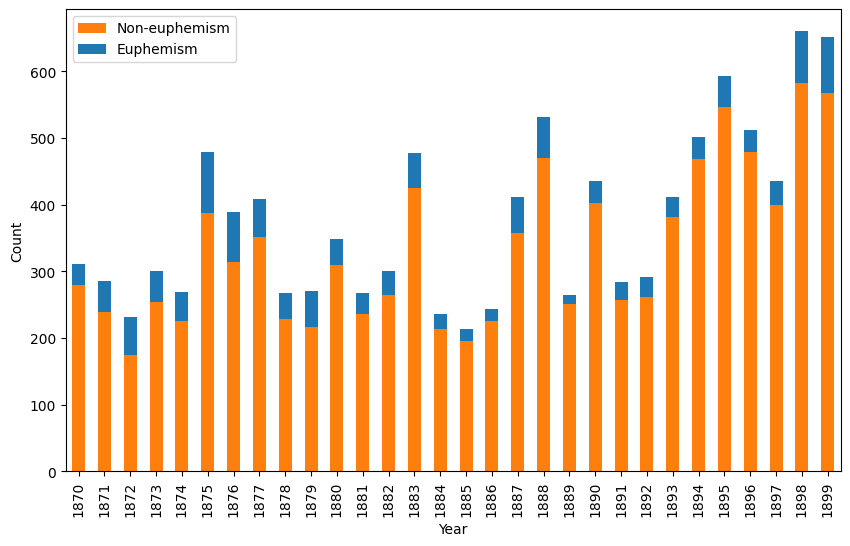

In [ ]:
# prompt: I want to plot the distribution of "Yes"= Euphemism and "No"= Non-euphemism from df_unlabeled['label'] over year from df_unlabeled['Year']. Sort them by year. use stack bar.

import matplotlib.pyplot as plt

# Group data by year and label
grouped_data = df_unlabeled.groupby(['Year', 'label'])['label'].count().unstack().fillna(0)

# Sort by year
grouped_data = grouped_data.sort_index()

# Create the stacked bar plot
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['C1', 'C0'])

# Set plot labels and title
plt.xlabel("Year")
plt.ylabel("Count")
# plt.title("Distribution of Euphemism and Non-Euphemism Over Year")
plt.legend(['Non-euphemism', 'Euphemism'])
# Save the plot with higher resolution
plt.savefig('/content/drive/MyDrive/Nors/Euphemisms of Death/Figures/Euphemism_Non-euphmism_distribution_overtime.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()
